In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import wget
import dask
import os
from tqdm import tqdm
import glob
import os

from numpy import linalg as LA
import math
import sklearn.preprocessing
import bahc

%matplotlib inline

## Data loading & pre-processing

In [2]:
@dask.delayed
def process_stock_raw(filename: str):
    pair = filename[21:filename.index('.us')]
    asset_data = pd.read_csv(filename)
    # asset_data["time"] = pd.to_datetime(asset_data["Open"], unit='ms')
    asset_data[pair] = asset_data["Close"]
    asset_data["Datetime"] = pd.to_datetime(asset_data["Date"])
    asset_data = asset_data.loc[:,["Datetime", pair]]
    date_indexed = asset_data.set_index("Datetime")
    if not date_indexed.shape[1] == 1:
        print(pair)
        print(date_indexed)
    return date_indexed

In [3]:
def merge_stock(pd_arr, col: str):
    assets_close_matrix = pd_arr[0]
    for each in pd_arr[1:]:
        assets_close_matrix = assets_close_matrix.merge(each, how="outer", on=col)
    return assets_close_matrix

def load_one_stock(filenames):
    tasks = [process_stock_raw(file) for file in filenames]
    p_data_arr = dask.compute(tasks)
    return p_data_arr[0]

def execute_load_and_merge_all_stock():
    files = glob.glob("data/spot/Day/Stocks/*")
    print("Number of assets: ", len(files))
    chunk_sz = 1000
    subsets = [files[i:i + chunk_sz] for i in range(0, len(files), chunk_sz)]
    # print(sum([len(each) for each in subsets]))
    for i in tqdm(range(len(subsets))):
        chunk = subsets[i]
        tmp_assets_arr = load_one_stock(chunk)
        # print(tmp_assets_arr)
        tmp_merge_result = pd.concat(tmp_assets_arr, axis=1)
        tmp_merge_result.sort_index()
        tmp_merge_result.to_pickle(f"data/clean/mk_{i}.pkl")
    
execute_load_and_merge_all_stock()

  0%|          | 0/8 [00:00<?, ?it/s]

Number of assets:  7195


100%|██████████| 8/8 [00:51<00:00,  6.44s/it]


In [4]:
df_arr = [pd.read_pickle(f"data/clean/mk_{i}.pkl") for i in range(8)]
res = pd.concat(df_arr, axis=1)
res.to_pickle("data/clean/whole_archive_stock_merge.pkl")
print(res.shape)

(14101, 7195)


## MVP functions

In [5]:
def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)
    
    
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    
    
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean    


def solution_eig(C_asset):
    C_corr = C_asset.corr()
    l_e, V_e = LA.eig(C_corr)
    T, N = C_asset.shape
    q = N/T
    lambda_plus = (1+np.sqrt(q))**2
    
    C_clipped=eigenvalue_clipping(l_e,V_e,lambda_plus)
    return C_clipped

def weights_GVM(Sigma):
    Sigma_inv=LA.inv(Sigma)
    w_GVM=Sigma_inv.sum(axis=1)/Sigma_inv.sum()
    return w_GVM
    

## Data preprocessing

In [6]:
all_data = pd.read_pickle("data/clean/whole_archive_stock_merge.pkl")
all_data = all_data.reset_index()
all_data = all_data.drop(["Datetime"], axis=1)
all_data

,iba,wpz,opnt,indf,flic,nbhc,ncs,grvy,lgcyo,eqco,...,uzb,nbl,ceixw,nrim,lmat,atu,jhy,xco,mik,apf
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14096,58.02,36.70,31.74,32.65,30.15,33.93,16.70,75.84,5.04,25.2500,...,25.52,26.30,NaN,37.231,32.930,26.40,9.9600,0.5200,21.60,18.05
14097,57.48,37.01,30.56,32.21,29.90,33.63,16.45,73.66,5.20,25.2500,...,25.79,27.00,NaN,36.634,32.765,26.65,10.0300,0.5290,21.94,17.93
14098,57.82,36.93,31.36,32.72,30.30,33.65,16.40,74.82,5.00,25.2100,...,25.81,26.84,NaN,37.678,31.390,26.95,10.0600,0.5471,21.15,17.83
14099,57.64,36.35,30.41,32.22,29.90,33.07,16.15,76.50,4.92,25.2389,...,25.96,26.63,NaN,37.330,31.690,26.35,10.1400,0.7000,21.40,17.82


In [7]:
log_ret_all_data = np.log(all_data).diff()

In [8]:
log_ret_all_data

,iba,wpz,opnt,indf,flic,nbhc,ncs,grvy,lgcyo,eqco,...,uzb,nbl,ceixw,nrim,lmat,atu,jhy,xco,mik,apf
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14096,-0.001395,0.036913,-0.041653,0.034905,-0.027802,-0.014629,0.015083,0.083565,0.018019,0.001585,...,-0.007029,0.014940,NaN,-0.001315,-0.014172,0.005698,0.004024,-0.160122,0.110001,-0.003915
14097,-0.009351,0.008411,-0.037886,-0.013568,-0.008326,-0.008881,-0.015083,-0.029166,0.031253,0.000000,...,0.010524,0.026268,NaN,-0.016165,-0.005023,0.009425,0.007004,0.017160,0.015618,-0.006670
14098,0.005898,-0.002164,0.025841,0.015710,0.013289,0.000595,-0.003044,0.015625,-0.039221,-0.001585,...,0.000775,-0.005944,NaN,0.028100,-0.042872,0.011194,0.002987,0.033643,-0.036672,-0.005593
14099,-0.003118,-0.015830,-0.030762,-0.015399,-0.013289,-0.017387,-0.015361,0.022206,-0.016129,0.001146,...,0.005795,-0.007855,NaN,-0.009279,0.009512,-0.022515,0.007921,0.246449,0.011751,-0.000561


In [17]:
t0 = 13800
t1 = 14000
X_raw = log_ret_all_data.iloc[t0:t1].dropna(axis=1)
X_raw

,iba,wpz,indf,flic,nbhc,ncs,lgcyo,eqco,gpk,wti,...,dmo,uzb,nbl,nrim,lmat,atu,jhy,xco,mik,apf
13800,0.018273,0.032697,0.000000,0.013200,0.003758,0.011027,0.049480,-0.001900,0.002212,0.062132,...,-0.002493,-0.001834,0.044508,0.011460,-0.014433,0.032476,0.005615,0.058841,-0.002486,0.000000
13801,-0.011228,-0.009700,0.000000,-0.018125,-0.009357,-0.013803,0.022728,-0.001174,-0.020388,0.047068,...,-0.009082,-0.008727,0.024208,-0.012242,-0.022125,-0.023057,-0.021090,0.000000,-0.003740,-0.000269
13802,-0.022862,-0.017860,0.000000,0.009080,0.003866,0.013803,0.017818,0.000365,0.027507,0.011429,...,-0.002998,0.006481,0.005301,0.024376,0.010183,0.039964,0.018134,0.018868,0.006225,0.003962
13803,0.012086,-0.015759,0.000000,-0.015259,-0.005565,-0.008950,-0.006645,-0.002718,-0.014437,-0.005698,...,0.008826,0.005179,0.009758,-0.010142,0.001526,0.014504,-0.010572,0.045670,0.006598,-0.000335
13804,0.010578,-0.024038,0.000000,0.003636,0.003829,0.003452,-0.011173,-0.001952,-0.010217,-0.064920,...,-0.000473,-0.006734,-0.014773,-0.004722,-0.001017,-0.005495,-0.003618,-0.018019,-0.008669,-0.004030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.020192,-0.008727,0.000000,-0.012302,-0.010601,0.011696,-0.047924,0.000791,-0.005735,0.026527,...,0.010591,0.005998,0.026686,-0.006482,-0.135339,0.006101,-0.001011,0.004556,-0.018785,0.002448
13996,-0.011187,0.001031,0.000000,-0.005314,0.001428,0.008683,-0.075508,0.000395,0.000000,0.025841,...,0.000354,0.000776,-0.001781,-0.016442,0.045120,0.008037,0.000000,-0.046520,-0.038084,0.006701
13997,0.007356,0.008692,0.000000,-0.003582,-0.000565,0.014306,0.071865,0.018399,0.004286,0.000000,...,0.001492,0.000388,0.005733,0.014823,0.021332,0.002009,0.005043,0.037388,0.029120,0.012670
13998,0.011623,0.004686,0.000000,-0.017997,-0.002352,-0.008559,-0.003656,-0.010921,0.004340,-0.015424,...,0.013059,-0.000776,0.012869,-0.001655,-0.027496,-0.022286,-0.001007,-0.013857,0.023910,0.002993


Text(0, 0.5, 'log-returns ^GSPC')

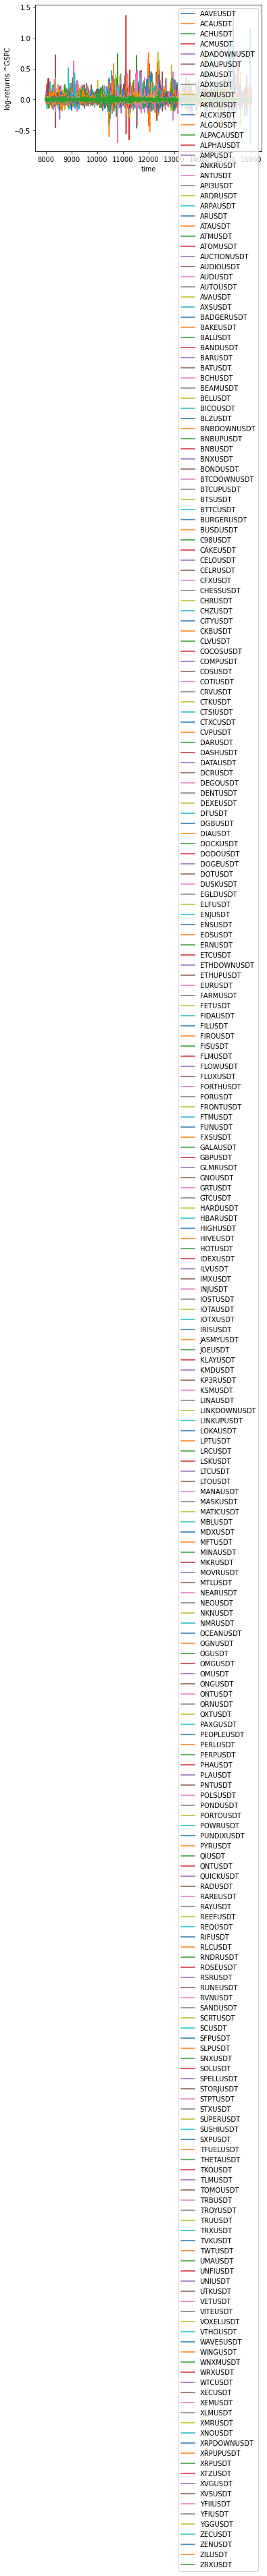

In [13]:
X_raw.plot()
plt.xlabel("time")
plt.ylabel("log-returns")

In [14]:
all_data_length = X_raw.shape[0]
T = 1000
N = 253

step_range = 6000
step_size = 6

In [21]:
C_asset_in = X_raw.iloc[0:0+T]
temp = C_asset_in.corr()
temp

,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AIONUSDT,AKROUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
AAVEUSDT,1.000000,0.490724,0.362430,0.405357,-0.810936,0.816101,0.822101,0.599196,0.548793,0.783780,...,0.707102,0.635961,0.545108,0.813217,0.765221,0.690989,0.623248,0.700350,0.810344,0.782402
ACAUSDT,0.490724,1.000000,0.248852,0.287960,-0.521646,0.527663,0.527527,0.391266,0.362941,0.476824,...,0.452351,0.414609,0.370330,0.510124,0.457515,0.478053,0.385320,0.457534,0.515200,0.493639
ACHUSDT,0.362430,0.248852,1.000000,0.219508,-0.357007,0.367083,0.365186,0.294574,0.285777,0.368602,...,0.326955,0.293994,0.262150,0.383455,0.362005,0.325483,0.258602,0.313062,0.382087,0.375082
ACMUSDT,0.405357,0.287960,0.219508,1.000000,-0.377384,0.401373,0.398509,0.288926,0.308167,0.390942,...,0.344731,0.350170,0.313971,0.415743,0.376883,0.348816,0.274397,0.321343,0.392855,0.390773
ADADOWNUSDT,-0.810936,-0.521646,-0.357007,-0.377384,1.000000,-0.970682,-0.983125,-0.595468,-0.531131,-0.749562,...,-0.697062,-0.631505,-0.563237,-0.775474,-0.717925,-0.682809,-0.600035,-0.676768,-0.788401,-0.741091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YGGUSDT,0.690989,0.478053,0.325483,0.348816,-0.682809,0.683351,0.690301,0.524874,0.470440,0.672359,...,0.582610,0.541734,0.488460,0.690271,0.634734,1.000000,0.503629,0.580777,0.678370,0.629995
ZECUSDT,0.623248,0.385320,0.258602,0.274397,-0.600035,0.616262,0.611272,0.427000,0.396272,0.625904,...,0.586054,0.548295,0.423597,0.637140,0.599691,0.503629,1.000000,0.709686,0.632522,0.612699
ZENUSDT,0.700350,0.457534,0.313062,0.321343,-0.676768,0.692631,0.691559,0.503088,0.479590,0.715570,...,0.645405,0.678343,0.473254,0.729066,0.667888,0.580777,0.709686,1.000000,0.742301,0.710581
ZILUSDT,0.810344,0.515200,0.382087,0.392855,-0.788401,0.799527,0.800769,0.566339,0.550852,0.792816,...,0.726632,0.636696,0.532088,0.817629,0.747231,0.678370,0.632522,0.742301,1.000000,0.790844


In [22]:
for i in range(0, step_range, step_size):
    C_asset_in = X_raw.iloc[i:i+T]
    C_asset_out = X_raw.iloc[i+T:i+2*T]
    
    print(type(C_asset_in))
    
    # print(C_asset_in.shape, C_asset_out.shape)
    
    # eigenvalue
    C_clipped_in = solution_eig(C_asset_in)
    # print(C_clipped_in.shape)
    
    W_eig = weights_GVM(C_clipped_in)
    
    # bahc
    X_centered = sklearn.preprocessing.StandardScaler(with_mean=True,
                           with_std=False).fit_transform(C_asset_in.values)  # column-wise!'
    Sigma_BAHC=bahc.filterCovariance(X_centered.T)
    w_GBM_BAHC=weights_GVM(Sigma_BAHC)
    
    # print(C_asset_in.cov().shape)
    C_in_cov = C_asset_in.cov()
    C_out_cov = C_asset_out.cov()
    
    # in sample risk
    sigma_in_eig= W_eig.T@(C_in_cov@W_eig)
    
    sigma_in_BAHC= w_GBM_BAHC@(C_in_cov@w_GBM_BAHC)
    
    # out sample risk
    sigma_out_eig= W_eig.T@(C_out_cov@W_eig)
    
    sigma_out_BAHC= w_GBM_BAHC@(C_out_cov@w_GBM_BAHC)
    
    # print(C_asset_in.corr())
    
    print(f"{i}, in: {sigma_in_BAHC}, out: {sigma_out_BAHC}")
    # print(f"{i}, in: {sigma_in_eig[0][0]}, out: {sigma_out_eig[0][0]}")
    
    # break
    
    
    

<class 'pandas.core.frame.DataFrame'>
0, in: 1.4601378086145325e-08, out: 1.1415483737759154e-08
<class 'pandas.core.frame.DataFrame'>
6, in: 1.3894643420259445e-08, out: 1.0971466544071251e-08
<class 'pandas.core.frame.DataFrame'>
12, in: 1.3794274479470031e-08, out: 1.0859975097559115e-08
<class 'pandas.core.frame.DataFrame'>
18, in: 1.3914179798934983e-08, out: 1.086199407728645e-08
<class 'pandas.core.frame.DataFrame'>
24, in: 1.366131206693664e-08, out: 1.0807396717305814e-08
<class 'pandas.core.frame.DataFrame'>
30, in: 1.3474676024471013e-08, out: 1.0660129083055059e-08
<class 'pandas.core.frame.DataFrame'>
36, in: 1.3762070641744573e-08, out: 1.0833122816172762e-08
<class 'pandas.core.frame.DataFrame'>
42, in: 1.3509128611078174e-08, out: 1.0724164636298773e-08
<class 'pandas.core.frame.DataFrame'>
48, in: 1.3501211427662788e-08, out: 1.050062027217434e-08
<class 'pandas.core.frame.DataFrame'>
54, in: 1.3083341171278426e-08, out: 1.0220130007043921e-08
<class 'pandas.core.frame

KeyboardInterrupt: 